In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats.mstats as ssm

%matplotlib inline

## Data cleaning: 

Data cleaning and Assumptions

- Drop items whose `rater` column is Nan. 
- Convert the career statistics to their expectations per game. It is more reasonable to compare their expectations. Image a player who play 20 games and 50 games with same performance(temper/position/goals/referee...), we should classifier them to same class. The total statistics will be very different while the averaged stats will be similar.
- Average the rater's score and binarize them to 0 (light skin) or 1 (dark skin)
- Convert country/club name to index.
- Trucate the birthday to the year. We assume that all the players enter leagues at similar age. Thus the information of birthday makes referees' creterion comparable overtime. For example, one action is considered admissible during a period of time but will get a yellow card in other time. If we compare the number of red cards of white players in 1980s with those of black players in 2010s, we may get wrong conclusions.
- Features like `photoID`, `player` is not used because their information are covered by `player-short` and `rater`
- stats like `meanAIT` are weighted with the number of games in a referee-player dyad. Togethor with `games`, the new stats will represent the total(average) `AIT` a player faced.

In [39]:
# load the data
filename = 'CrowdstormingDataJuly1st.csv'
df_all = pd.read_csv(filename)

df_all.dropna(inplace=True)

Feature Engineering

In [40]:
df_all['Skin'] = ((df_all['rater1'] + df_all['rater2']) > 1 ).astype(int)
df_all['totalCards'] = (df_all['redCards'] + df_all['yellowCards'] + df_all['yellowReds'])
df_all['weightIAT'] = df_all['meanIAT'] * df_all['games']
df_all['weightExp'] = df_all['meanExp'] * df_all['games']

In [41]:
# replace birthday by the birth year
df_all['birthday'] = df_all.apply(lambda x: x.loc['birthday'].split('.')[2], axis=1).astype(int)

# replace country name by number labels in order to classify
dic_country = {'Spain':0, 'France':1, 'England':2, 'Germany':3}
df_all['leagueCountry'] = df_all.apply(lambda x: dic_country[x.loc['leagueCountry']], axis=1)

# replace club name by number labels in order to classify
club_name = df_all['club'].unique()
num_of_clubs = len(club_name)
club_index = np.arange(0, num_of_clubs)
club_name_index_map = dict(zip(club_name, club_index))
df_all['club'] = df_all.apply(lambda x: club_name_index_map[x.loc['club']], axis=1)

In [42]:
# replace position name by number labels in order to classify
position_name = df_all['position'].unique()
num_of_position = len(position_name)
position_index = np.arange(0, num_of_position)
position_name_index_map = dict(zip(position_name,position_index))

df_all['position'] = df_all.apply(lambda x: position_name_index_map[x.loc['position']], axis=1)

In [43]:
rev_position_name_index_map = {v:k for k, v in position_name_index_map.items()}

In [44]:
df_all.head() 

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,Skin,totalCards,weightIAT,weightExp
0,lucas-wilchez,Lucas Wilchez,0,0,1983,177.0,72.0,0,1,0,...,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0,0,0.326391,0.396000
1,john-utaka,John Utaka,1,1,1982,179.0,82.0,1,1,0,...,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,1,1,0.203375,-0.204082
5,aaron-hughes,Aaron Hughes,2,2,1979,182.0,71.0,2,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0,0,0.325185,0.538462
6,aleksandar-kolarov,Aleksandar Kolarov,3,2,1985,187.0,80.0,3,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0,0,0.325185,0.538462
7,alexander-tettey,Alexander Tettey,4,2,1986,180.0,68.0,4,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1,0,0.325185,0.538462


#### Create a new dataframe of size (`num_player`, `num_feaures`) of each player.

In [45]:
rev_club_name_index_map = {v:k for k,v in club_name_index_map.items()}

In [46]:
# Aggragate player's stats by summing
df_player = df_all[['playerShort','totalCards', 'redCards', 'yellowCards', 
                    'yellowReds', 'victories', 'ties', 'weightIAT', 'weightExp',
                    'defeats', 'goals', 'games']].groupby('playerShort').sum()

# the birthday, position, skin are the same for each player, so using `mean` will not change.
df_player[['birthday','position', 'skin', 'club', 'leagueCountry', 'height','weight']] = df_all[
    ['playerShort', 'birthday', 'position', 'Skin', 'club', 'leagueCountry'
    , 'height','weight']].groupby('playerShort').mean()

#### Create a new dataframe of each player with stats per game

In [47]:
df_ave = df_player.copy()

averaged_list = ['totalCards','yellowCards', 'yellowReds', 'redCards', 'victories', 'ties', 
                 'defeats', 'goals', 'weightIAT', 'weightExp']
for feature in averaged_list:
    df_ave[feature] = df_ave[feature]/df_ave['games']

Analyse the skin with the red/yellow cards they receive. From this simple stats, we found the number of cards received per game are similar. Light skin player receives a little more yellow cards, while dark skin player receive more red cards.

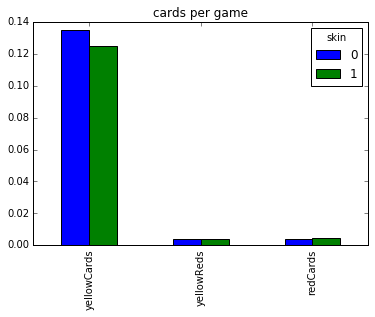

In [48]:
skin_x_cards = df_player.groupby('skin').sum()[['yellowCards', 'yellowReds', 'redCards', 'games']]

for card in ['yellowCards', 'yellowReds', 'redCards']:
    skin_x_cards[card] = skin_x_cards[card] / skin_x_cards['games']

skin_x_cards[['yellowCards', 'yellowReds', 'redCards']].transpose().plot(kind='bar')
plt.title('cards per game')
plt.show()

### classification objective visionlization

Compare the number of players with their age and skin color. We found the number of player with light skin color is much more than dark skin. As the portion of young players have `light` skin than those born in 1980s, it is reasonable to think many dark skin player come from countries outside this 4 leagues.

More importantly, we will have to choose an appropriate metric which measures the `desired` accuracy and a better learning option (use `class_weight=balanced_subsample` when we define classifier). In this case, we use `F1` score to choose a model as it garauntees both precision and recall. In this way, we can leviate the effect of **imbalanceness**.

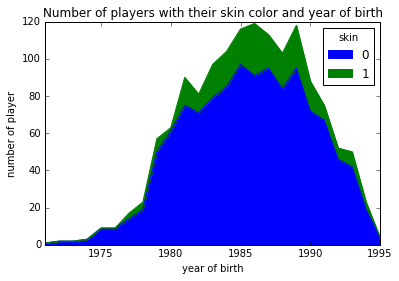

In [49]:
rater_average = df_player[['skin', 'birthday', 'games']]
rater_birth_count = rater_average.groupby(['skin', 'birthday']).count()
rater_birth_count = rater_birth_count.reset_index()
pivoted_rater_birth_count = rater_birth_count.pivot(columns='skin', values='games', index='birthday').fillna(0)
pivoted_rater_birth_count.plot(kind='area')
plt.ylabel('number of player')
plt.xlabel('year of birth')
plt.title('Number of players with their skin color and year of birth')
plt.show()

#### Positions

Some positions are more likely to get red cards than the others. We first take a look at their distributions.

In [50]:
position_x_skin_df = df_player.groupby(['position', 'skin']).sum()
for feature in ['totalCards', 'redCards', 'yellowCards', 'yellowReds', 'victories',
               'ties', 'weightIAT', 'weightExp', 'defeats', 'goals']:
    position_x_skin_df[feature] = position_x_skin_df[feature]/position_x_skin_df['games']

In [51]:
position_x_skin_df.head()

totalCards  redCards  yellowCards  yellowReds  victories  \
position skin                                                             
0        0       0.128570  0.002584     0.123232    0.002754   0.467288   
         1       0.135902  0.001605     0.130551    0.003745   0.407170   
1        0       0.114078  0.004108     0.108010    0.001960   0.477689   
         1       0.101413  0.003795     0.095298    0.002319   0.444444   
2        0       0.176751  0.006642     0.164081    0.006028   0.459571   

                   ties  weightIAT  weightExp   defeats     goals  games  \
position skin                                                              
0        0     0.229631   0.347319   0.446752  0.303081  0.161997  29408   
         1     0.246656   0.345080   0.416082  0.346174  0.167469   1869   
1        0     0.229742   0.350241   0.474613  0.292569  0.270911  10712   
         1     0.245414   0.337989   0.388015  0.310141  0.186802   4743   
2        0     0.235413   0.345425   0.439991  0.305016  0.053137  53748   

               birthday  club  leagueCountry   height   weight  
position skin                                                   
0        0       236445  4560            205  21094.0   8504.0  
         1        15900   293              7   1434.0    594.0  
1        0        79463  1708             58   7102.0   2902.0  
         1        31757   496             21   2844.0   1173.0  
2        0       418858  8218            342  39519.0  17037.0

In [52]:
position_x_skin_redCards = position_x_skin_df.reset_index()
position_x_skin_redCards['position'] = position_x_skin_redCards.apply(
    lambda x: rev_position_name_index_map[x.loc['position']], axis=1)

position_x_skin_redCards = position_x_skin_redCards.pivot(
    values='redCards', columns='skin', index='position')

In some positions like `center Back`, `Goal Keepers` and `right winger`, `right fullback`, the dark skin players got more cards than light skin players.

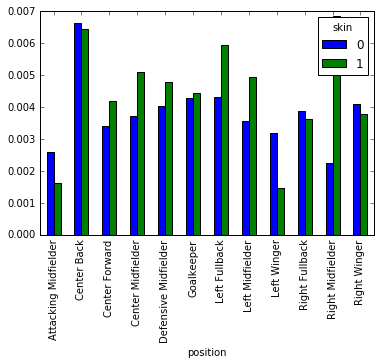

In [53]:
position_x_skin_redCards.plot(kind='bar')

#### Groupby Referees

In [54]:
df_all.ix[:5, 13:]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,Skin,totalCards,weightIAT,weightExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0,0,0.326391,0.396000
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,1,1,0.203375,-0.204082
5,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0,0,0.325185,0.538462


In [55]:
df_all.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp', 'Skin', 'totalCards', 'weightIAT',
       'weightExp'],
      dtype='object')

In [56]:
ref_df1 = df_all.groupby('refNum').sum()[['games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards']]
ref_df2 = df_all.groupby('refNum').mean()[['refCountry', 'meanIAT', 'nIAT', 'seIAT', 
                                 'meanExp', 'nExp', 'seExp']]

ref_df = pd.concat([ref_df1, ref_df2], axis=1)
ref_df.head()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
refNum,,,,,,,,,,,,,,,
1,1,0,0,1,0,0,0,0,1.0,0.326391,712.0,0.000564,0.396000,750.0,0.002696
2,1,0,0,1,0,1,0,0,2.0,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
4,32,22,4,6,2,2,0,0,4.0,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,5,4,0,1,1,0,0,0,6.0,0.322177,140.0,0.003344,0.117647,136.0,0.013721
7,77,32,17,28,9,8,0,1,7.0,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586


Something funny~

In [57]:
ref_df = df_all.groupby(['refNum', 'Skin']).sum()
ref_df = ref_df[ref_df.games > 22]
ref_df['redCards'] = ref_df['redCards']/ref_df['games']

In [58]:
ref_df.head()

club  leagueCountry  birthday  height  weight  position  games  \
refNum Skin                                                                   
4      0      271             57     53623  4960.0  2066.0        85     31   
7      0      584             20     37688  3395.0  1363.0        90     39   
       1      490             22     37747  3454.0  1425.0        95     38   
16     0      552             43     35729  3245.0  1313.0        96     41   
20     0      689             33     43690  3953.0  1641.0        91     23   

             victories  ties  defeats    ...      refCountry   meanIAT  \
refNum Skin                              ...                             
4      0            22     4        5    ...             108  8.779999   
7      0            16     8       15    ...             133  6.358994   
       1            16     9       13    ...             133  6.358994   
16     0            30     9        2    ...             234  7.745022   
20     0            18     2        3    ...             374  7.559911   

                nIAT     seIAT    meanExp     nExp     seExp  totalCards  \
refNum Skin                                                                
4      0      3429.0  0.089014  14.538462   3510.0  0.371310           2   
7      0     54758.0  0.002867   6.385918  57209.0  0.011133           5   
       1     54758.0  0.002867   6.385918  57209.0  0.011133           4   
16     0     49878.0  0.002625  11.683773  51912.0  0.009494           5   
20     0      1584.0  0.155641   8.105263   1672.0  0.586315           4   

             weightIAT  weightExp  
refNum Skin                        
4      0     10.080740  16.692308  
7      0     13.052672  13.107938  
       1     12.717988  12.771837  
16     0     17.641439  26.613037  
20     0      7.903543   8.473684  

[5 rows x 26 columns]

In [59]:
ref_df_plot = ref_df.reset_index().pivot(columns='Skin', values='redCards', index='refNum').fillna(0)
ratio = ref_df_plot[0].sum()/ref_df_plot[1].sum()
print('the average number of red cards given to black player: ',ref_df_plot[1].sum())
print('the average number of red cards given to white player: ',ref_df_plot[0].sum())
print('the ratio of red cards given to white and black player: ',ratio)

the average number of red cards given to black player:  1.38126455456
the average number of red cards given to white player:  4.56618028071
the ratio of red cards given to white and black player:  3.30579704346


If a ref officiated a full game in one of our selected premier leagues they would be in at least 22 dyads (2 teams of 11 players each, more if substitutions occur). Here, we select all ref that have at least 22 dyads, then we compute the average red card they gave to black skin player and white skin player, and the result shows that they give 3.3 times more red cards to white player than black player.

## Assignment 1

We first deal with the overfitting problem. Given data contains 2 rater's score for skin darkness and we are required to train a classifier to estimate player's skin color from other feature. Since we cannot judge whether our estimation is correct or not for those which does not have the rater's score, we decide to drop these data and we use the rest of the data (named *training_data_x*) to train our classifier. 

We observe that there is a certain amount of rater score for the same player. If we simply randomly partition *training_data_x*, both the training data and the testing data will high likely to contain the rater score for the same player, then the classifier will check player's *birthday*, *height*, *weight* in order to verify the player and use the result from training data to testing data, which will give us high *clf_score*. 

However, this is not a faire classifier and we ignore all other features apart from three features mentioned above. Through a precise discussion and brain storm, we figure out that we should group the data by *playerShort* and get the mean value. Again, we cannot calculate the mean value of the string, such as *club, leagueCountry, refNum, refCountry, Alpha_3*, even if we label these string by unique number.

Add features like `clubs` into df_new

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [61]:
def cross_validation(name_list, K):
    np.random.shuffle(name_list)
    num_train = len(name_list) // K
    name_list = np.array(name_list)
    for i in range(K):
        te = np.arange(i * num_train, (i+1)*num_train)
        tr = [i for i in range(len(name_list)) if i not in te]
        yield name_list[tr], name_list[te]

In [62]:
def shuffle_names(name_list, ratio):
    np.random.shuffle(name_list)
    num_train = int(len(name_list) * ratio)
    return name_list[:num_train], name_list[num_train:]

### overfitting curve

To see the overfitting phenomenon, we groupby the dataframe with their name and aggregate the dyad information. This classifier performs very good on the trainging set (almost  99%) as the classifier is able to create enough trees to remember every player. 

However, this classifier behaves not as good on the test sets around (85%). The gap between training error and testing error is about 15% which is pretty large. Thus our model know have overfitting the datasets.

In fact, this classifier is useless if we checkout the `f1 score` and fusion matrix, we will find the `f1 score` is very small and the fusion matrix shows we have assgin new datapoints to `light skin`. It means our model is way too simple.

In [63]:
featuer_list1 = ['totalCards', 'redCards', 'yellowCards', 'yellowReds', 'victories',
       'ties', 'weightIAT', 'weightExp', 'defeats', 'goals', 'games',
       'birthday', 'position', 'club', 'leagueCountry', 'height','weight']
training_data_player_x = df_player[featuer_list1]
training_data_player_y = df_player['skin']

In [64]:
clf = RandomForestClassifier(n_estimators=30, class_weight="balanced_subsample")
portion = 0.80
n = training_data_player_x.shape[0]
temp_set = np.random.permutation(range(n))
training_idx = [i for i in temp_set if i < n * portion]
test_idx = [i for i in temp_set if i > n * portion]

x_tr = training_data_player_x.iloc[training_idx]
y_tr = training_data_player_y.iloc[training_idx]
x_te = training_data_player_x.iloc[test_idx]
y_te = training_data_player_y.iloc[test_idx]

clf.fit(X=x_tr, y=y_tr)
y_pred = clf.predict(x_te)
print("training error = ", 1-clf.score(x_tr, y_tr), ", test error = ", 1-clf.score(x_te, y_te))

training error =  0.00264084507042 , test error =  0.13074204947


In [65]:
print("F1 score = ", f1_score(y_true=y_te,y_pred=y_pred))

F1 score =  0.139534883721


In [66]:
print("fusion matrix for \n", confusion_matrix(y_true=y_te,y_pred=y_pred))

fusion matrix for 
 [[243   1]
 [ 36   3]]


### Reduce Overfitting

#### Approach 1
One way to reduce overfitting is to reduce the noise our classifier obtained from training dataset. In the above overfitting example, we didn't limit the maximum depth of randomforest, meaning the classifier can create split node as much as it want. It also means that random noise can also be used to split node. 

Beside, the number of estimators we use is very large (`30`). It allows the classifier to choose the model overfit the datasets rather than the inner structure.

Thus, we are going to limit the maximum depth and number of estimators. We will use cross validation to show our strategy improves the performance

In [67]:
def reduce_overfitting(n_estimators, max_depth, training_data_player_x, training_data_player_y, K=5):
    prediction_list = []
    training_score_list = []
    testing_score_list = []
    recall_score_list = []
    name_list = training_data_player_x.reset_index()['playerShort'].unique()
    for tr_idx, te_idx in cross_validation(name_list, K=K):
        x_tr = training_data_player_x.loc[tr_idx]
        y_tr = training_data_player_y.loc[tr_idx]
        x_te = training_data_player_x.loc[te_idx]
        y_te = training_data_player_y.loc[te_idx]

        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight="balanced_subsample")

        clf.fit(X=x_tr, y=y_tr)
        y_pred = clf.predict(x_te)
        prediction_list.append(f1_score(y_true=y_te, y_pred=y_pred))
        training_score_list.append(clf.score(x_tr, y_tr))
        testing_score_list.append(clf.score(x_te, y_te))
        recall_score_list.append(recall_score(y_true=y_te, y_pred=y_pred))
    #     print("training error = ", training_score_list[-1], ", test error = ", testing_score_list[-1])
    #     print("fusion matrix  = \n", confusion_matrix(y_true=y_te, y_pred=y_pred))
    print("n_estimators = {:>3}, max_depth ={:>3}, f1 score = {:6.3}".format(n_estimators, max_depth, np.mean(np.array(prediction_list))))
    print("training = {:6.3}, testing = {:6.3}, recall = {:6.3}".format(np.mean(np.array(training_score_list)), np.mean(np.array(testing_score_list)),np.mean(np.array(recall_score_list))))
    
    return clf, np.mean(np.array(prediction_list)), np.mean(np.array(training_score_list)), np.mean(np.array(testing_score_list)),np.mean(np.array(recall_score_list))

In [68]:
for n_estimators in range(8, 16,2):
    for max_depth in range(1, 10):
        reduce_overfitting(n_estimators, max_depth,training_data_player_x, training_data_player_y)

n_estimators =   8, max_depth =  1, f1 score =  0.305
training =  0.621, testing =  0.587, recall =  0.575
n_estimators =   8, max_depth =  2, f1 score =  0.333
training =  0.632, testing =  0.608, recall =  0.613
n_estimators =   8, max_depth =  3, f1 score =  0.379
training =  0.693, testing =  0.671, recall =  0.632
n_estimators =   8, max_depth =  4, f1 score =  0.356
training =  0.752, testing =   0.69, recall =  0.543
n_estimators =   8, max_depth =  5, f1 score =  0.345
training =   0.82, testing =  0.728, recall =  0.453
n_estimators =   8, max_depth =  6, f1 score =  0.366
training =  0.836, testing =  0.753, recall =  0.441
n_estimators =   8, max_depth =  7, f1 score =  0.355
training =  0.872, testing =  0.766, recall =  0.404
n_estimators =   8, max_depth =  8, f1 score =   0.32
training =  0.913, testing =  0.785, recall =   0.32
n_estimators =   8, max_depth =  9, f1 score =   0.28
training =  0.933, testing =  0.789, recall =  0.258
n_estimators =  10, max_depth =  1, f

As we can see, by choosing a better parameter, the overfitting can be reduced 

n_estimators =  10, max_depth =  8, f1 score =   0.31
training =  0.925, testing =   0.78, recall =  0.309


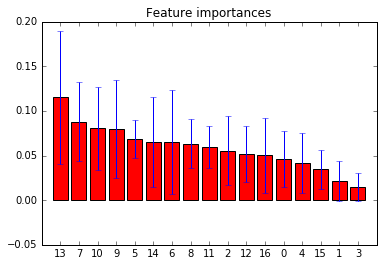

In [69]:
n_estimators=10
max_depth=8
clf,_,_,_,_ = reduce_overfitting(n_estimators, max_depth, training_data_player_x, training_data_player_y)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(training_data_player_x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(training_data_player_x.shape[1]), indices)
plt.xlim([-1, training_data_player_x.shape[1]])
plt.show()

#### If we drop feature even before feeding data

The importances of features may change locally, but the overall order is similar.

n_estimators =  10, max_depth =  8, f1 score =  0.245
training =  0.912, testing =  0.767, recall =  0.237


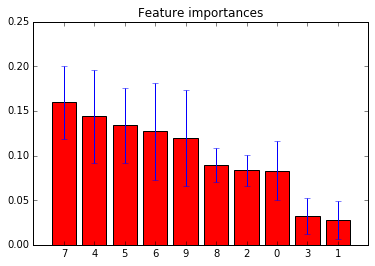

In [70]:
n_estimators=10
max_depth=8

feature_sets = np.arange(10)
training_datasets = training_data_player_x.ix[:, feature_sets]
clf,_,_,_,_ = reduce_overfitting(n_estimators, max_depth, training_datasets, training_data_player_y)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(training_datasets.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(training_datasets.shape[1]), indices)
plt.xlim([-1, training_datasets.shape[1]])
plt.show()

#### Approach 2 (Training dyad)

Gathering more data is a very common way to reduce data. Unfortuntly, we can't get gather more information of player due to time limitation. However, we can train the player-referee dyad directly with careful choice of features.

Let's take each dyad as training example and split the whole dataframe into 2 parts: one for training and one for testing.

The key issue here is to avoid introducing specific information about a player, say the `club`, `leagueCountry`, `height` and `weight`. Otherwise, these information try to find the exact player rather than try to find out the relation between `player` with dyad

In [71]:
columns_to_be_averaged = ['victories', 'ties','defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']
column_name_not_training = [ 'player', 'refNum', 'refCountry', 
                            'Alpha_3', 'rater1', 'rater2', 'photoID', 
                            'club', 'leagueCountry', 'birthday', 'height', 
                            'weight', 'position', 'totalCards']
column_name_training = [i for i in df_all.columns if i not in column_name_not_training]
training_df = df_all[df_all.games > 1][column_name_training].copy()

for col in columns_to_be_averaged:
    training_df[col] = training_df[col] / training_df['games']
    
# del training_df['games']
training_df.set_index('playerShort', inplace=True)
column_name_training.remove('Skin')
column_name_training.remove('playerShort')

In [88]:
indices = training_df.index

cols = column_name_training
training_data_x = training_df[cols]
training_data_y = training_df['Skin']
player_name_list = list(set(training_data_x.index))

#### Influence of different set of parameters to RandomForestClassifier. 

This method may not perform so well as each player will be feed to the classfier several times. But the overfitting is greatly reduced.

In [94]:
n_estimators = 30
max_features = 10
clf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, class_weight="balanced_subsample")

portion = 0.9
n = training_data_x.shape[0]
temp_set = np.random.permutation(range(n))

training_idx = [i for i in temp_set if i < n * portion]
test_idx = [i for i in temp_set if i > n * portion]

x_tr = training_data_x.iloc[training_idx]
y_tr = training_data_y.iloc[training_idx]
x_te = training_data_x.iloc[test_idx]
y_te = training_data_y.iloc[test_idx]

clf.fit(X=x_tr, y=y_tr)
y_pred = clf.predict(x_te)

print("f1_score = ", f1_score(y_true=y_te,y_pred=y_pred), 
      ", training error = ", clf.score(x_tr, y_tr), ", test error = ",clf.score(x_te, y_te))

f1_score =  0.308817204301 , training error =  0.799744527666 , test error =  0.720034843206


## Bonus

Using the first approach, plot the learning learning curve.

Remark: As 20 fold of cross validation is time consuming and can cause high varaiance (as training sets are very similar), we decide to use 5 folded crossvalidation which is used most often.

In [224]:
def name_range(df, ratio):
    """Select a set of names for training and splitting"""
    names = df.index
    n = df.shape[0]
    idx = np.random.permutation(np.arange(n))[:int(n*ratio)]
    return names[idx]

In [225]:
n_estimators=20
max_depth=10

train_error_list = []
test_error_list = []
problem_size_list = []

for ratio in np.linspace(0.3, 0.9, num=10):
    names = name_range(training_data_player_x, ratio)
    _, _, train_error, test_error, _ = reduce_overfitting(n_estimators, max_depth, training_data_player_x.loc[names], 
                                                     training_data_player_y.loc[names])
    train_error_list.append(train_error)
    test_error_list.append(test_error)
    problem_size_list.append(len(names))

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


n_estimators =  20, max_depth = 10, f1 score = 0.0308
training =  0.992, testing =  0.824, recall =  0.025
n_estimators =  20, max_depth = 10, f1 score =   0.15
training =  0.994, testing =  0.838, recall = 0.0958
n_estimators =  20, max_depth = 10, f1 score =  0.162
training =  0.993, testing =  0.848, recall =  0.108
n_estimators =  20, max_depth = 10, f1 score =  0.204
training =   0.99, testing =  0.823, recall =  0.137
n_estimators =  20, max_depth = 10, f1 score =  0.219
training =  0.986, testing =  0.825, recall =  0.156
n_estimators =  20, max_depth = 10, f1 score =  0.199
training =  0.988, testing =  0.837, recall =  0.134
n_estimators =  20, max_depth = 10, f1 score =  0.281
training =  0.985, testing =  0.845, recall =  0.189
n_estimators =  20, max_depth = 10, f1 score =  0.324
training =  0.982, testing =  0.841, recall =  0.237
n_estimators =  20, max_depth = 10, f1 score =  0.328
training =  0.978, testing =  0.837, recall =  0.248
n_estimators =  20, max_depth = 10, f

We can see the test error is decreasing while the testing error is increasing. 

This is because with the growing of training sets, classifier loses the accuracy for each datapoint in order to fit more data. At the same time, with more datapoints, classifier can filter out noise better.

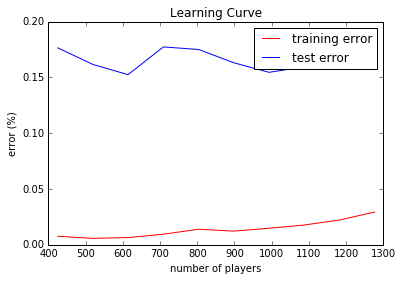

In [227]:
plt.figure()
plt.plot(problem_size_list, 1-np.array(train_error_list), 'r',label='training error')
plt.plot(problem_size_list, 1-np.array(test_error_list), 'b',label='test error')
plt.title("Learning Curve")
plt.xlabel("number of players")
plt.ylabel("error (%)")
plt.legend()
plt.show()

## Assignment 2

### PCA preview

We use PCA to preview if there are two disjoint clusters at 2D plot for all possible combonation of selected features: *redCards*, *yellowCards*, *yellowReds*, *victories*,*ties*, *weightIAT*, *weightExp*, *defeats*, *goals*. We did not use feature *skin* since this feature will be used to evaluate if two cluster represents dark skin and white skin player. If we put it in the selected feature list, we can simply just use this feature and get the two cluster; however, it is pointless.

In order to do PCA, we have to scale the data, which means that we should remove the mean and set the variance to 1 for each feature.

In [ ]:
# load the data
filename = 'CrowdstormingDataJuly1st.csv'
df2 = pd.read_csv(filename)

In [129]:
df_ave.ix[:4,:]

,totalCards,redCards,yellowCards,yellowReds,victories,ties,weightIAT,weightExp,defeats,goals,games,birthday,position,skin,club,leagueCountry,height,weight
playerShort,,,,,,,,,,,,,,,,,,
aaron-hughes,0.029052,0.000000,0.029052,0.0,0.377676,0.273700,0.333195,0.400637,0.348624,0.013761,654,1979,2,0,2,2,182.0,71.0
aaron-hunt,0.127976,0.002976,0.125000,0.0,0.419643,0.217262,0.341438,0.380811,0.363095,0.184524,336,1986,0,0,41,3,183.0,73.0
aaron-lennon,0.026699,0.000000,0.026699,0.0,0.485437,0.235437,0.332389,0.399459,0.279126,0.075243,412,1987,10,0,12,2,165.0,63.0
aaron-ramsey,0.123077,0.003846,0.119231,0.0,0.576923,0.161538,0.336638,0.433294,0.261538,0.150000,260,1990,9,0,37,2,178.0,76.0


In [143]:
# useful fearure
a = ['redCards', 'yellowCards', 'yellowReds', 'victories',
       'ties', 'weightIAT', 'weightExp', 'defeats', 'goals']
df_ave_new = df_ave[a]

In [145]:
df_ave_new.head()

,totalCards,redCards,yellowCards,yellowReds,victories,ties,weightIAT,weightExp,defeats,goals
playerShort,,,,,,,,,,
aaron-hughes,0.029052,0.000000,0.029052,0.000000,0.377676,0.273700,0.333195,0.400637,0.348624,0.013761
aaron-hunt,0.127976,0.002976,0.125000,0.000000,0.419643,0.217262,0.341438,0.380811,0.363095,0.184524
aaron-lennon,0.026699,0.000000,0.026699,0.000000,0.485437,0.235437,0.332389,0.399459,0.279126,0.075243
aaron-ramsey,0.123077,0.003846,0.119231,0.000000,0.576923,0.161538,0.336638,0.433294,0.261538,0.150000
abdelhamid-el-kaoutari,0.112903,0.016129,0.064516,0.032258,0.330645,0.322581,0.331882,0.328895,0.346774,0.008065


In [148]:
# scaling
from sklearn import preprocessing
df_scale = preprocessing.scale(df_ave_new)
df_scale = pd.DataFrame(df_scale, columns=a)

In [150]:
df_scale.head()

,totalCards,redCards,yellowCards,yellowReds,victories,ties,weightIAT,weightExp,defeats,goals
0,-1.406630,-0.728028,-1.378509,-0.690110,-0.583834,0.752065,-0.944384,-0.432718,0.253731,-0.816723
1,-0.198641,-0.231016,-0.136804,-0.690110,-0.149837,-0.444826,-0.386863,-0.623310,0.428638,0.679633
2,-1.435363,-0.728028,-1.408960,-0.690110,0.530563,-0.059389,-0.998836,-0.444045,-0.586244,-0.277975
3,-0.258468,-0.085736,-0.211467,-0.690110,1.476655,-1.626556,-0.711480,-0.118781,-0.798816,0.377108
4,-0.382701,1.965455,-0.919552,4.471819,-1.070195,1.788673,-1.033144,-1.122396,0.231375,-0.866644


In [151]:
from sklearn.decomposition import PCA

In [152]:
pca = PCA(n_components=2)

In [153]:
import itertools

['totalCards' 'redCards']


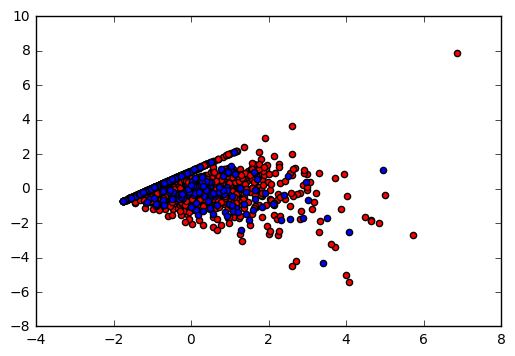

['totalCards' 'yellowCards']


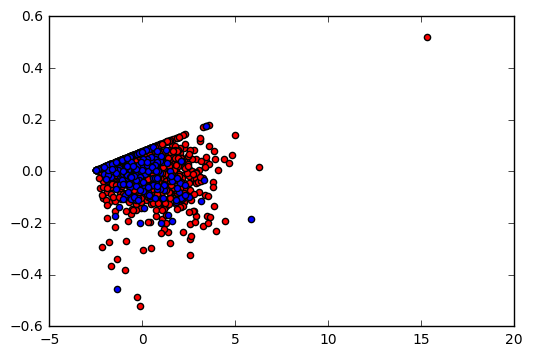

['totalCards' 'yellowReds']


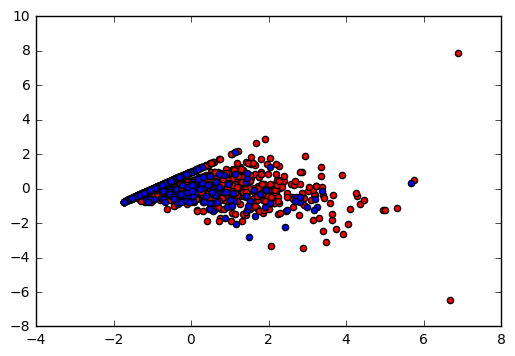

['totalCards' 'victories']


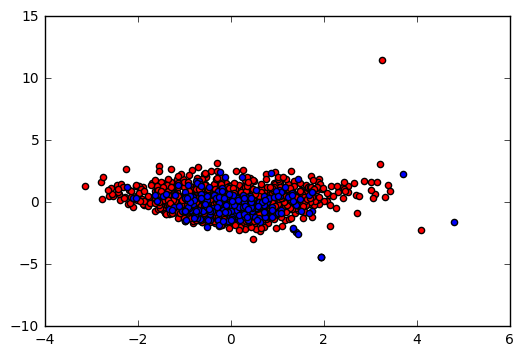

['totalCards' 'ties']


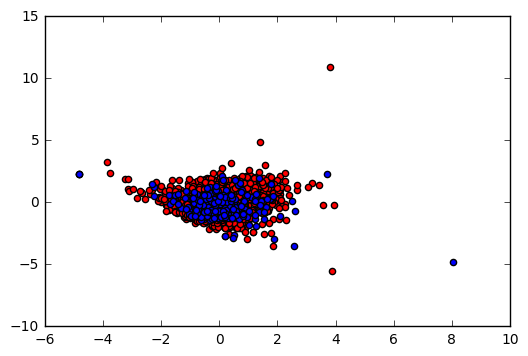

['totalCards' 'weightIAT']


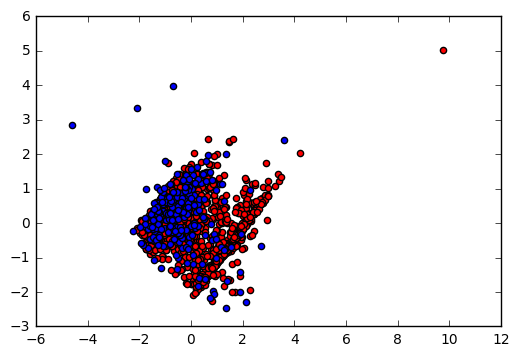

['totalCards' 'weightExp']


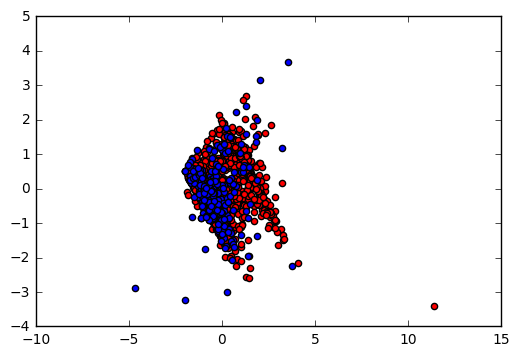

['totalCards' 'defeats']


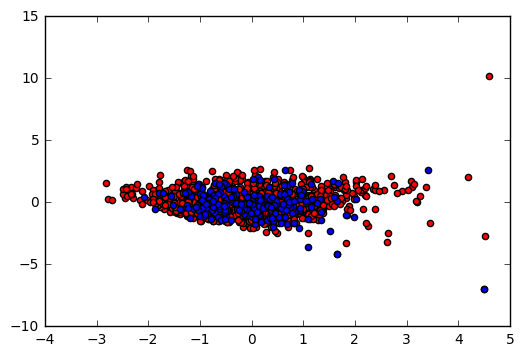

['totalCards' 'goals']


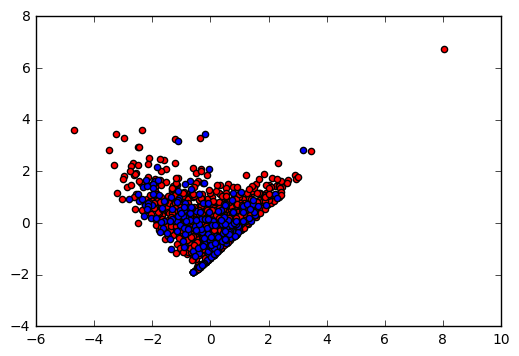

['redCards' 'yellowCards']


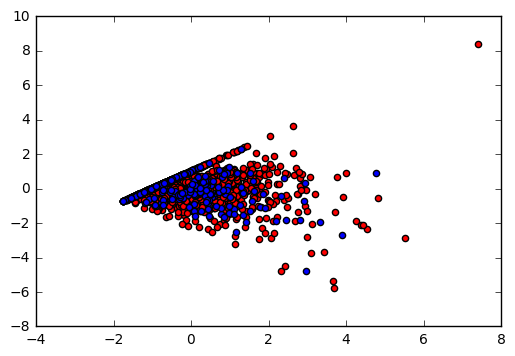

['redCards' 'yellowReds']


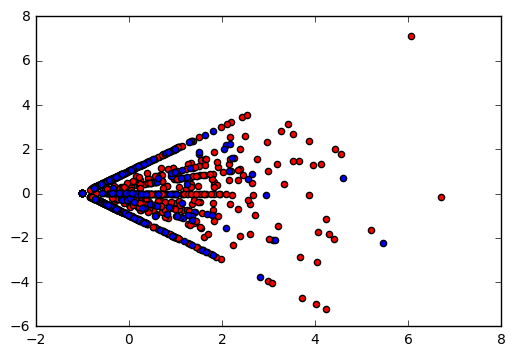

['redCards' 'victories']


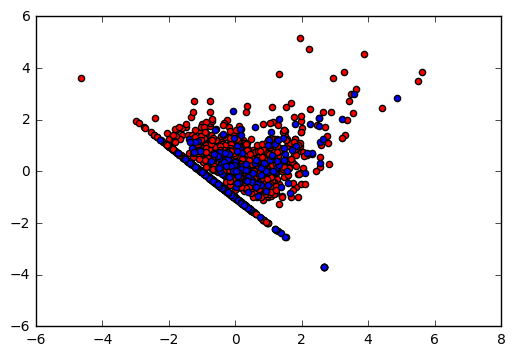

['redCards' 'ties']


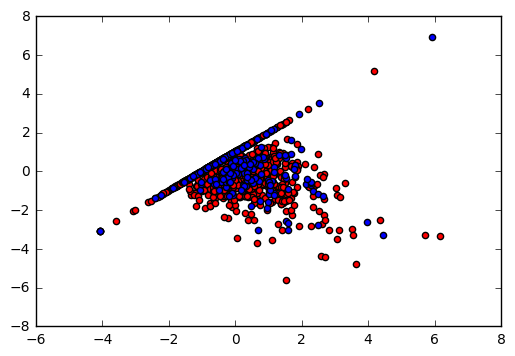

['redCards' 'weightIAT']


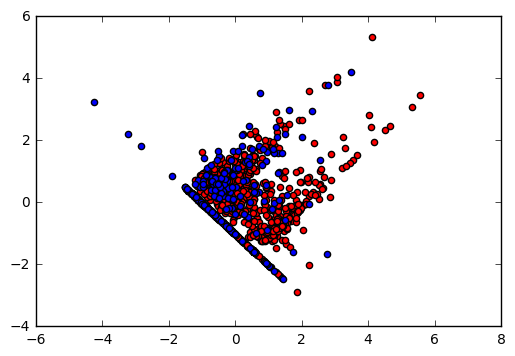

['redCards' 'weightExp']


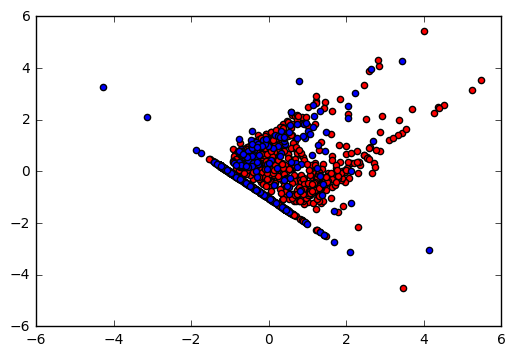

['redCards' 'defeats']


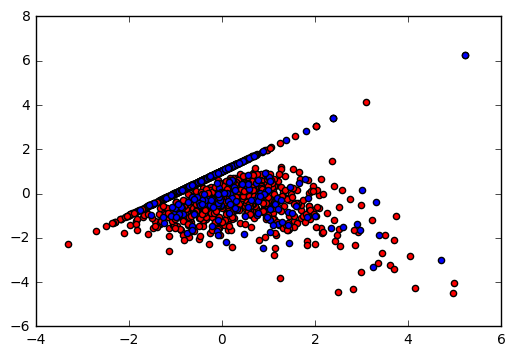

['redCards' 'goals']


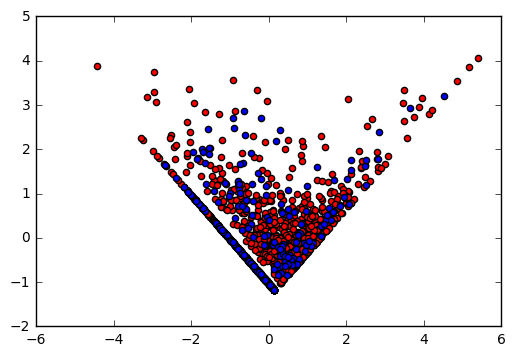

['yellowCards' 'yellowReds']


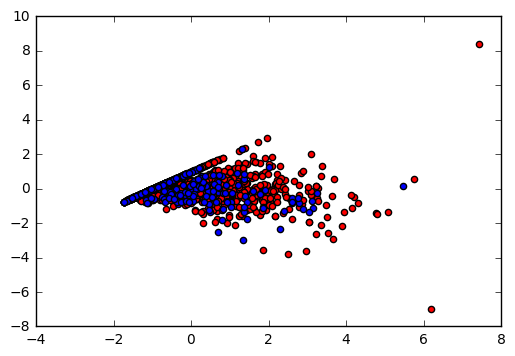

['yellowCards' 'victories']


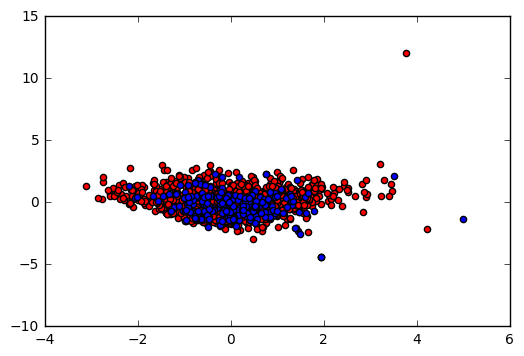

['yellowCards' 'ties']


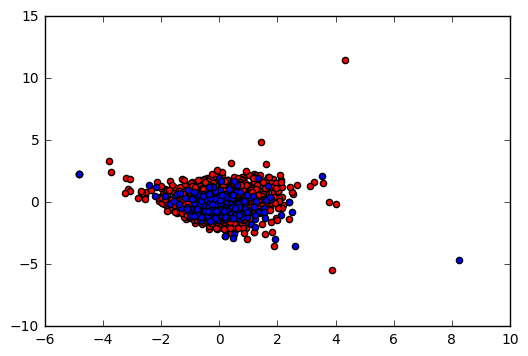

['yellowCards' 'weightIAT']


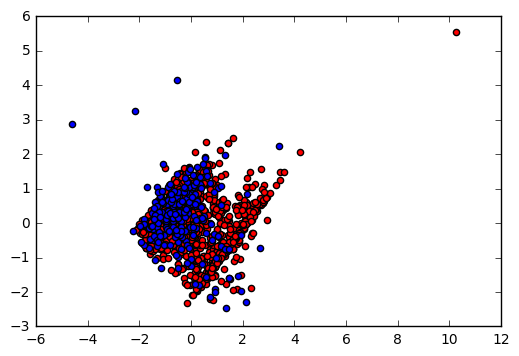

['yellowCards' 'weightExp']


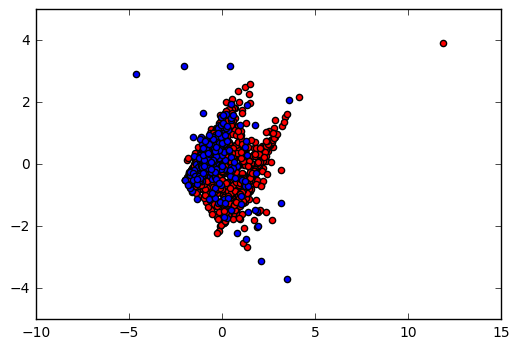

['yellowCards' 'defeats']


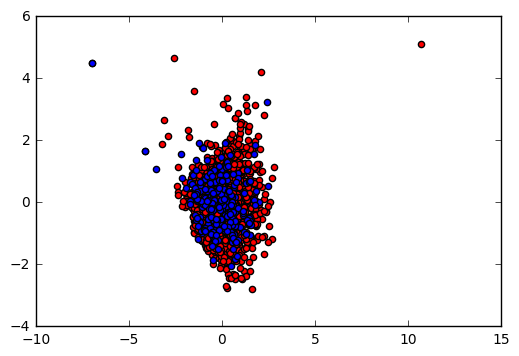

['yellowCards' 'goals']


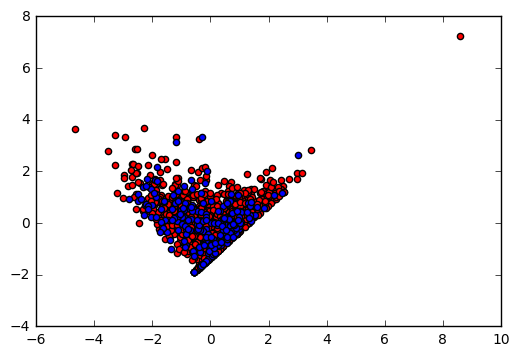

['yellowReds' 'victories']


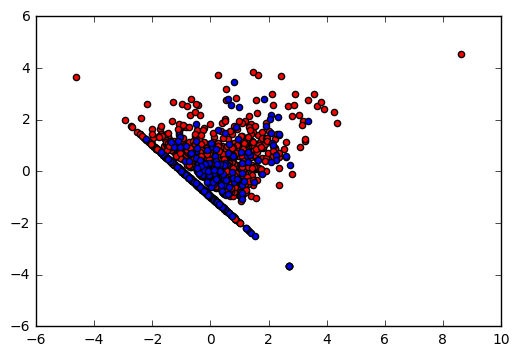

['yellowReds' 'ties']


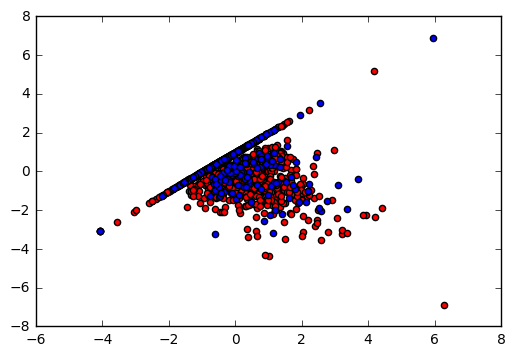

['yellowReds' 'weightIAT']


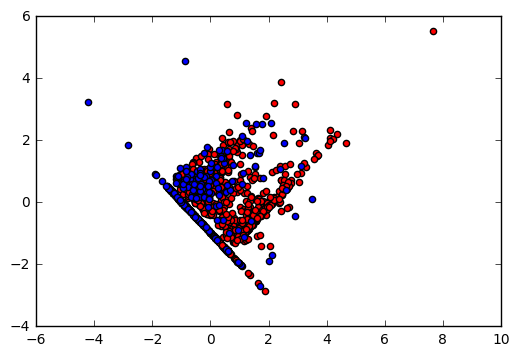

['yellowReds' 'weightExp']


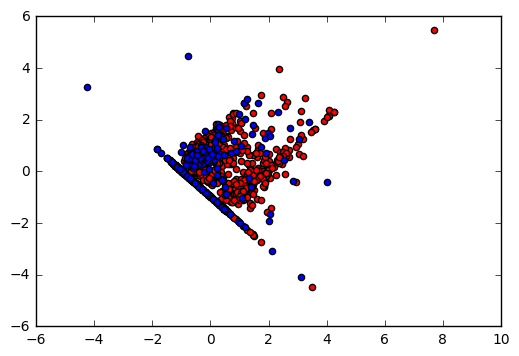

['yellowReds' 'defeats']


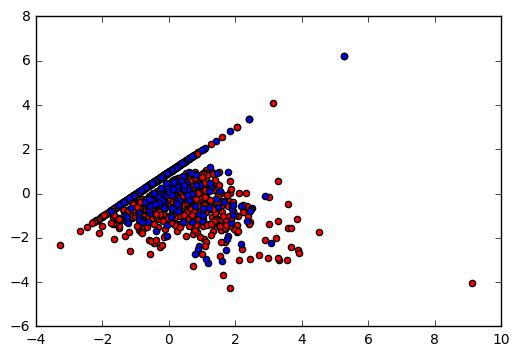

['yellowReds' 'goals']


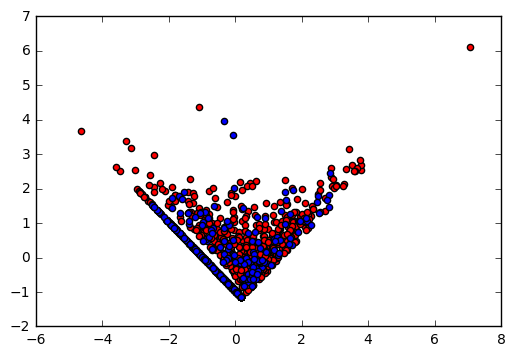

['victories' 'ties']


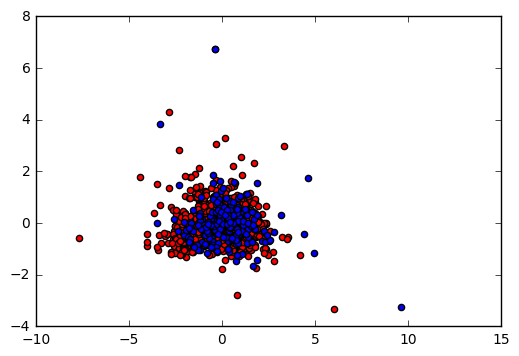

['victories' 'weightIAT']


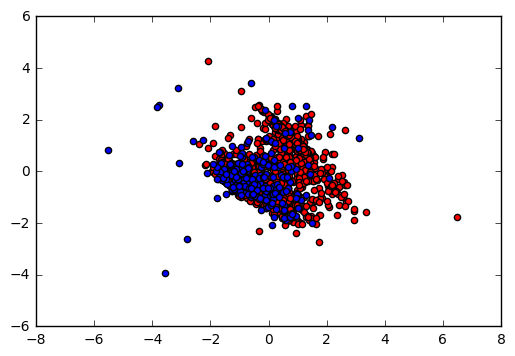

['victories' 'weightExp']


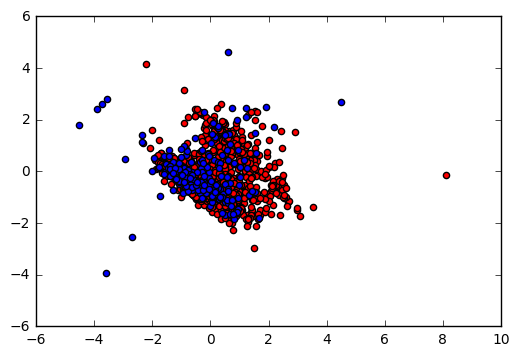

['victories' 'defeats']


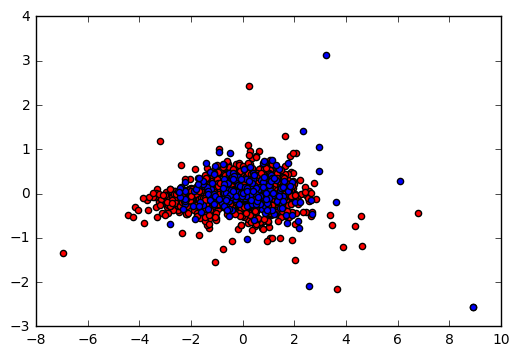

['victories' 'goals']


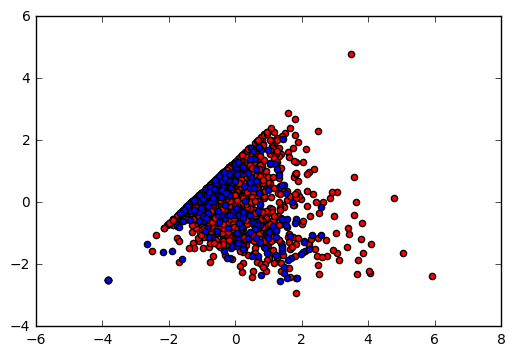

['ties' 'weightIAT']


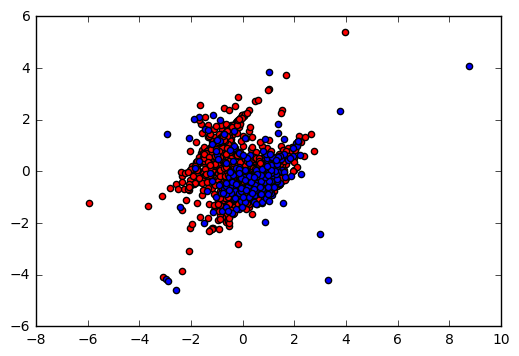

['ties' 'weightExp']


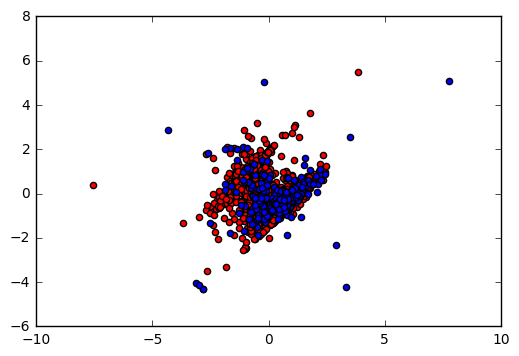

['ties' 'defeats']


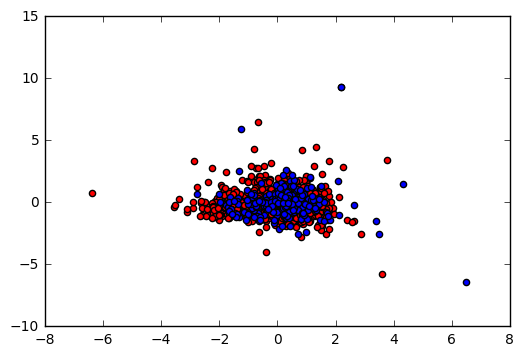

['ties' 'goals']


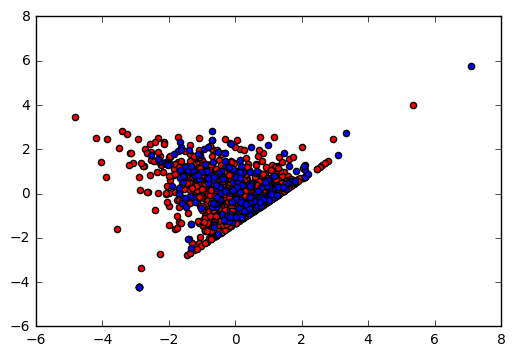

['weightIAT' 'weightExp']


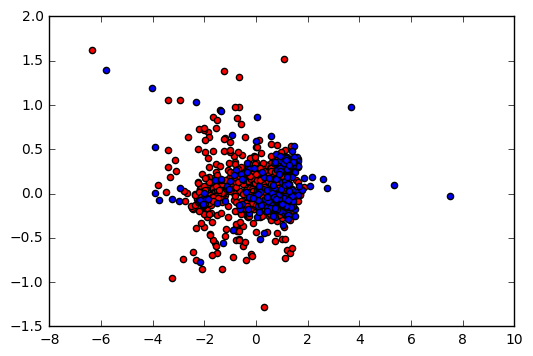

['weightIAT' 'defeats']


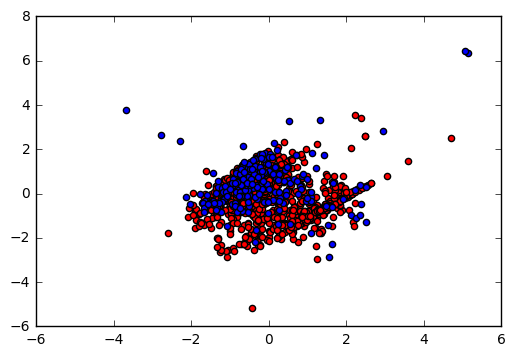

['weightIAT' 'goals']


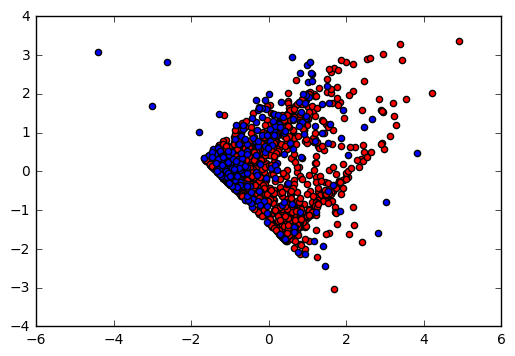

['weightExp' 'defeats']


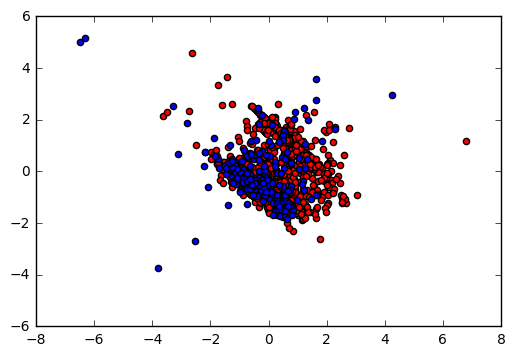

['weightExp' 'goals']


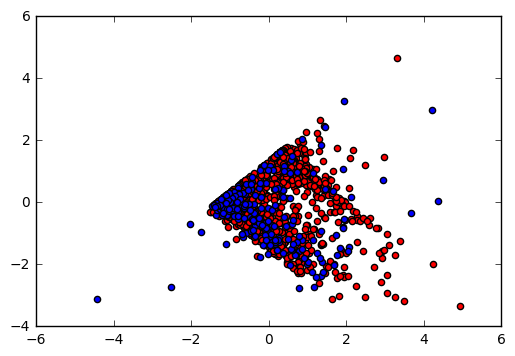

['defeats' 'goals']


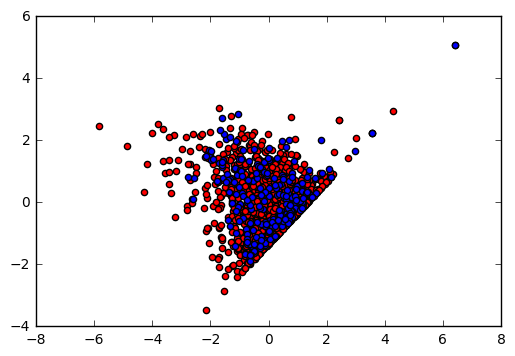

In [173]:
plt.plot()
index_color = np.argwhere(df_ave['skin'] == 0)
index_color2 = np.argwhere(df_ave['skin'] == 1)
for i in itertools.combinations(range(10), 2):
    print(np.asarray(a)[np.asarray(i)])
    A = pca.fit_transform(df_scale[np.asarray(a)[np.asarray(i)]])
    plt.scatter(A[index_color[:,0],0][:],A[index_color[:,0],1][:], c='r')
    plt.scatter(A[index_color2[:,0],0][:],A[index_color2[:,0],1][:], c='b')
    plt.show()

From the above plot, red and blue points represent light skin and dark skin player respectively.

Observe that no matter which feature(s) we choose, the projection of the data to 2D cannot be clustered into two based on skin color.

Hence, we assume that no matter which method we use to cluster the data, we cannot atain two disjoint cluster, one of which represents dark skin player and the other represents light skin player.

### DBSCAN clustering

We verify our assumption discribed above by clustering the players into 2 clusters by DBSCAN. 
- Based on Dataframe `df_ave` created before, we keep the features relative to players' skin prediction, like `redcards`,
- Based on Dataframe `df_ave` created before, we drop the features relative to players' personal information, like `height`,`weight`,`skin`,`club` and so on. 
- we scale the data preparing for the choice of DBSCAN's `eps`.
- Adjusting `eps`，`min_samples` and number of features to find ideal cluster. Than compare the cluster result and real players' skin colour.



In [347]:
# load the data
filename = 'CrowdstormingDataJuly1st.csv'
df2 = pd.read_csv(filename)

In [348]:
df_ave_copy=df_ave.copy()
# compute the numebr of white player and black player
num_black = df_ave_copy.groupby('skin').count().ix[1,1]
num_white = df_ave_copy.groupby('skin').count().ix[0,1]
print('The number of black skin player is: ', num_black)
print('The number of white skin player is: ', num_white)

The number of black skin player is:  227
The number of white skin player is:  1192


In [349]:
# choose features from df_ave 
feature_list_string = ['redCards','yellowCards','yellowReds',
                        'victories','ties','weightIAT','weightExp','defeats','goals']
df_cluster=df_ave_copy[feature_list_string]

In [350]:
df_cluster.head()

,redCards,yellowCards,yellowReds,victories,ties,weightIAT,weightExp,defeats,goals
playerShort,,,,,,,,,
aaron-hughes,0.000000,0.029052,0.000000,0.377676,0.273700,0.333195,0.400637,0.348624,0.013761
aaron-hunt,0.002976,0.125000,0.000000,0.419643,0.217262,0.341438,0.380811,0.363095,0.184524
aaron-lennon,0.000000,0.026699,0.000000,0.485437,0.235437,0.332389,0.399459,0.279126,0.075243
aaron-ramsey,0.003846,0.119231,0.000000,0.576923,0.161538,0.336638,0.433294,0.261538,0.150000
abdelhamid-el-kaoutari,0.016129,0.064516,0.032258,0.330645,0.322581,0.331882,0.328895,0.346774,0.008065


In [351]:
# scaling the data
from sklearn import preprocessing
df_scale = preprocessing.scale(df_cluster)
df_scale = pd.DataFrame(df_scale, columns=feature_list_string)
df_scale.head()

,redCards,yellowCards,yellowReds,victories,ties,weightIAT,weightExp,defeats,goals
0,-0.728028,-1.378509,-0.690110,-0.583834,0.752065,-0.944384,-0.432718,0.253731,-0.816723
1,-0.231016,-0.136804,-0.690110,-0.149837,-0.444826,-0.386863,-0.623310,0.428638,0.679633
2,-0.728028,-1.408960,-0.690110,0.530563,-0.059389,-0.998836,-0.444045,-0.586244,-0.277975
3,-0.085736,-0.211467,-0.690110,1.476655,-1.626556,-0.711480,-0.118781,-0.798816,0.377108
4,1.965455,-0.919552,4.471819,-1.070195,1.788673,-1.033144,-1.122396,0.231375,-0.866644


In [352]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import itertools

The idea is that we do exhausting search for all combination of features and different eps and sample number. For each iteration, we compute the *number of different labels*, *number of outliers*, *sample numebr*, *silhouette_score*, *ratio_total_cards_cluster0*,*ratio_total_cards_cluster_rest*. Last two evaluate how good we split the data into two disjoint cluster and each cluster represent one skin color player. In other words, the higher score, the denser the same skin color player in the cluster.

In fact, we cannot always obtain two disjoint cluster. We use the largest cluster as one resulting cluster and then we group the rest cluster into another cluster.

In [353]:
# compute all the combination of features
combination_list = []
N = len(feature_list_string)
for i in range(1,N+1):
    for j in itertools.combinations(range(N), i):
        combination_list.append(j)

In [354]:
# function to compute the DBSCAN labels
def DBSCAN_labels(eps_num, samples_num, data_frame):
    db = DBSCAN(eps=eps_num, min_samples=samples_num).fit(data_frame)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    return labels

In [355]:
# function to compute ratio of total cards between white and black player at the biggest cluster
# warning: if denomina is 0, then the ratio will be more than 10^4
def ratio_total_cards_cluster0(labels):
    nomina = df_ave_copy.ix[np.argwhere(df_ave_copy.ix[np.argwhere(pd.Series(labels) == 
                                                                   0)[:,0],-5] == 0)[:,0],0].mean()
    denomina = df_ave_copy.ix[np.argwhere(df_ave_copy.ix[np.argwhere(pd.Series(labels) == 
                                                                     0)[:,0],-5] == 1)[:,0],0].mean()
    return nomina/(denomina+1e-6)

In [356]:
# function to compute ratio of total cards between white and black player at the rest cluster
# warning: if denomina is 0, then the ratio will be more than 10^4
def ratio_total_cards_cluster_rest(labels):
    nomina = df_ave_copy.ix[np.argwhere(df_ave_copy.ix[np.argwhere(pd.Series(labels) != 0)[:,0],-5] == 
                                        0)[:,0],0].mean()
    denomina = df_ave_copy.ix[np.argwhere(df_ave_copy.ix[np.argwhere(pd.Series(labels) != 0)[:,0],-5] == 
                                          1)[:,0],0].mean()
    return nomina/(denomina+1e-6)

In [357]:
num_outlier=[]
num_zero_label = []
eps_list=[]
samples_list=[]
feature_choose=[]
label_num=[]
sil_score = []
ratio_total_cards_cluster0_list = []
ratio_total_cards_cluster_rest_list = []

check_progress = 1
for list_com in combination_list:
    print('Progress: ', 100*check_progress/511, '%')
    check_progress = check_progress + 1
    feature_list=np.array(feature_list_string)[np.asarray(list_com)]
    data = df_scale[feature_list[:]]
    for i in range(10,40):
        for samples_num in range(10,20):
            eps_num  = i/40
            labels = DBSCAN_labels(eps_num, samples_num, data)
            if len(set(labels))>2:
                eps_list.append(eps_num)
                samples_list.append(samples_num)
                feature_choose.append(list_com)
                num_outlier.append(pd.Series(pd.Series(labels).value_counts())[-1])
                num_zero_label.append(pd.Series(pd.Series(labels).value_counts())[0])
                ratio_total_cards_cluster0_list.append(ratio_total_cards_cluster0(labels))
                ratio_total_cards_cluster_rest_list.append(ratio_total_cards_cluster_rest(labels))
                label_num.append(len(set(labels)))
                sil_score.append(metrics.silhouette_score(df_scale[feature_list[:]], labels, 
                                                          metric='sqeuclidean'))

Progress:  0.19569471624266144 %
Progress:  0.3913894324853229 %
Progress:  0.5870841487279843 %
Progress:  0.7827788649706457 %
Progress:  0.9784735812133072 %
Progress:  1.1741682974559686 %
Progress:  1.36986301369863 %
Progress:  1.5655577299412915 %
Progress:  1.761252446183953 %
Progress:  1.9569471624266144 %
Progress:  2.152641878669276 %
Progress:  2.3483365949119372 %
Progress:  2.544031311154599 %
Progress:  2.73972602739726 %
Progress:  2.935420743639922 %
Progress:  3.131115459882583 %
Progress:  3.3268101761252447 %
Progress:  3.522504892367906 %
Progress:  3.7181996086105675 %
Progress:  3.9138943248532287 %
Progress:  4.109589041095891 %
Progress:  4.305283757338552 %
Progress:  4.500978473581213 %
Progress:  4.6966731898238745 %
Progress:  4.892367906066537 %
Progress:  5.088062622309198 %
Progress:  5.283757338551859 %
Progress:  5.47945205479452 %
Progress:  5.675146771037182 %
Progress:  5.870841487279844 %
Progress:  6.066536203522505 %
Progress:  6.262230919765166

In [391]:
# build dataframe to store cluster result
db_cluster = pd.DataFrame({'eps':eps_list,
                     'sample':samples_list,
                     'feature_select':feature_choose,
                     'outlier':num_outlier,
                        'label_num':label_num,
                           'ratio_total_cards_cluster0':ratio_total_cards_cluster0_list,
                           'ratio_total_cards_cluster_rest':ratio_total_cards_cluster_rest_list,
                          'sil_score': sil_score})
db_cluster.head()

,eps,feature_select,label_num,outlier,ratio_total_cards_cluster0,ratio_total_cards_cluster_rest,sample,sil_score
0,0.250,"(0,)",3,25,0.928801,0.897648,14,0.763188
1,0.275,"(0,)",3,20,0.928801,0.897648,14,0.783510
2,0.275,"(0,)",3,20,0.928801,0.897648,15,0.783510
3,0.275,"(0,)",3,27,0.928801,0.897648,16,0.755490
4,0.300,"(0,)",3,20,0.928801,0.897648,15,0.783510


In [392]:
db_cluster_copy=db_cluster.copy()
db_cluster_copy.dropna(inplace = True)

From the result, we want to find all the *eps*, *feature_select* and *sample_number* that maximize *ratio_total_cards_cluster0* and minimize *ratio_total_cards_cluster_rest* at the same time or the other way around, namely, minimize *ratio_total_cards_cluster0* and maximize *ratio_total_cards_cluster_rest*.

Now let's first look at the value of *ratio_total_cards_cluster0*. We scatter plot the value of *ratio_total_cards_cluster0* at below:

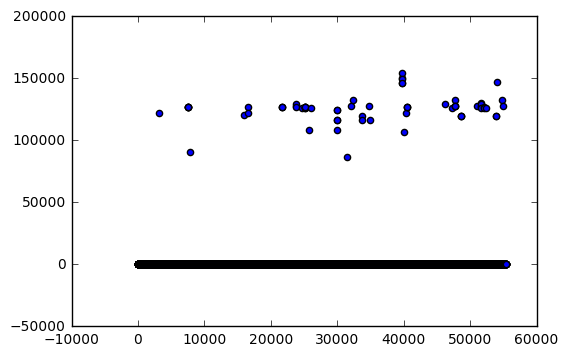

In [394]:
plt.figure()
y = db_cluster_copy['ratio_total_cards_cluster0']
x = np.arange(0, len(y))
plt.scatter(x, y)
plt.show()

We observe that there are several point that have extreme high value (more than 50000). These cases represent that there are not dark skin player in the cluster at that scenario. To split the dark skin player and light one, we also need another cluster to contain all dark skin player, which mean *ratio_total_cards_cluster_rest* will be as close to 0 as possible.

In [404]:
# all cases that ratio_total_cards_cluster0>50000
target_frame = db_cluster_copy[db_cluster_copy['ratio_total_cards_cluster0']>5e4]
target_frame.head()

,eps,feature_select,label_num,outlier,ratio_total_cards_cluster0,ratio_total_cards_cluster_rest,sample,sil_score
3110,0.250,"(1, 3, 8)",5,1192,122369.356129,1.011931,16,-0.361328
7478,0.275,"(0, 1, 3, 8)",6,1310,126636.176465,1.051031,10,-0.472160
7495,0.325,"(0, 1, 3, 8)",3,1334,126636.176465,1.051031,15,-0.396204
7506,0.350,"(0, 1, 3, 8)",3,1329,126636.176465,1.051031,17,-0.389562
7517,0.375,"(0, 1, 3, 8)",3,1292,126748.233277,1.072780,18,-0.356596


In [402]:
# find where the ratio_total_cards_cluster_rest is the minimum
target_frame[target_frame['ratio_total_cards_cluster_rest']==target_frame['ratio_total_cards_cluster_rest'].min()]

,eps,feature_select,label_num,outlier,ratio_total_cards_cluster0,ratio_total_cards_cluster_rest,sample,sil_score
25912,0.25,"(0, 2, 3, 5, 6)",4,1252,108244.578785,0.951882,12,-0.392303


From this, we see that *silhouette_score* is negetive, which is bad. Also, the outlier number is more than 1000, which means that majority of data is not clustered.

Further more, all of the **target_frame** contains more than 1000 outliers and negetive silhouette score. Hence, these scenarios cannot cluster data properly. If we look at *ratio_total_cards_cluster_rest* value more than 50000 cases, we will obtain the similar conclusion, we skip this analysis here.

Now we would like to look at those whose *ratio_total_cards_cluster0* is below 50000.

In [428]:
# all cases that ratio_total_cards_cluster0>50000
target_frame = db_cluster_copy[db_cluster_copy['ratio_total_cards_cluster0']<=5e4]
target_frame.head()

,eps,feature_select,label_num,outlier,ratio_total_cards_cluster0,ratio_total_cards_cluster_rest,sample,sil_score
0,0.250,"(0,)",3,25,0.928801,0.897648,14,0.763188
1,0.275,"(0,)",3,20,0.928801,0.897648,14,0.783510
2,0.275,"(0,)",3,20,0.928801,0.897648,15,0.783510
3,0.275,"(0,)",3,27,0.928801,0.897648,16,0.755490
4,0.300,"(0,)",3,20,0.928801,0.897648,15,0.783510


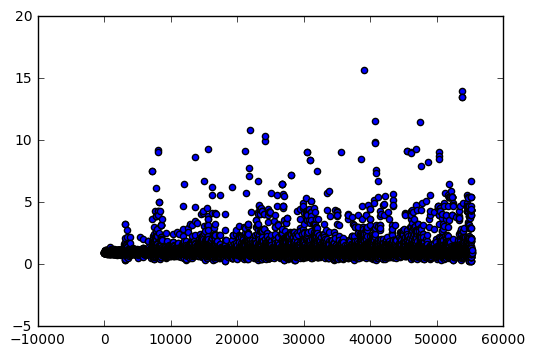

In [429]:
plt.figure()
y = target_frame['ratio_total_cards_cluster0']
x = np.arange(0, len(y))
plt.scatter(x, y)
plt.show()

As said before, the best splitting is with high *ratio_total_cards_cluster0* value (much more than 1) and low *ratio_total_cards_cluster_rest* value (close to 0) or the other way around.

#### high *ratio_total_cards_cluster0* value (much more than 1) and low *ratio_total_cards_cluster_rest* value (close to 0) case

In [430]:
# find where the ratio_total_cards_cluster_rest is the minimum
target_frame[target_frame['ratio_total_cards_cluster_rest']==target_frame['ratio_total_cards_cluster_rest'].min()]

,eps,feature_select,label_num,outlier,ratio_total_cards_cluster0,ratio_total_cards_cluster_rest,sample,sil_score
7,0.475,"(0,)",3,4,1.034938,0.363791,10,0.889841
8,0.500,"(0,)",3,4,1.034938,0.363791,10,0.889841
9,0.525,"(0,)",3,4,1.034938,0.363791,10,0.889841


At above cases, the *outliers* are very few and the *silhouette_score* is very close to 1 (very good!); however, there are equal dark skin player and light skin player at cluster0 and we cannot split those two kind of player properly.

#### high *ratio_total_cards_cluster_rest* value (much more than 1) and low *ratio_total_cards_cluster0* value (close to 0) case

In [433]:
# find where the ratio_total_cards_cluster0 is the minimum
target_frame[target_frame['ratio_total_cards_cluster0']==target_frame['ratio_total_cards_cluster0'].min()]

,eps,feature_select,label_num,outlier,ratio_total_cards_cluster0,ratio_total_cards_cluster_rest,sample,sil_score
18208,0.275,"(2, 4, 5, 7)",5,1250,0.310444,1.035153,10,-0.543629
18215,0.300,"(2, 4, 5, 7)",6,1228,0.310444,1.035153,12,-0.509944


At above case, the outlier number are huge and the clustering fail.

All in all, we cannot split the data into two disjoint clusters that contains light skin and dark skin player repectively. Therefore, we think there are no discrimination among dark skin player and light skin players. They are treated impartially.